In [ ]:
!pip install kaggle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np
import h5py
import time
from multiprocessing import Pool

if not os.path.exists('./plantvillage'):
    print("Dataset non trovato. Download in corso...")

    # Installa kaggle se non presente
    !pip install -q kaggle

    from google.colab import files
    # Upload del file kaggle.json solo se non esiste
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        files.upload()  # Upload file kaggle.json

        # Configura le credenziali Kaggle
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    # Download e estrazione del dataset
    !kaggle datasets download -d abdallahalidev/plantvillage-dataset
    !unzip plantvillage-dataset.zip -d ./plantvillage
    print("Dataset scaricato e estratto con successo!")
else:
    print("Dataset già presente in ./plantvillage")

Dataset già presente in ./plantvillage


In [ ]:
DATA_DIR = "plantvillage/plantvillage dataset/color"
IMG_SIZE = 224  # MobileNetV2 richiede input 224x224
BATCH_SIZE = 32

def create_data_generators():
    import os
    from sklearn.model_selection import train_test_split
    import pandas as pd

    # Preparazione dei file: ottieni la directory dei dati e le classi disponibili
    all_data_dir = os.path.join(DATA_DIR)  # Percorso alla directory principale
    classes = sorted(os.listdir(all_data_dir))  # Elenco delle sottodirectory (una per classe)

    # Creazione delle liste di percorsi dei file e delle rispettive etichette
    all_filepaths = []
    all_labels = []
    for label, class_dir in enumerate(classes):
        class_files = os.listdir(os.path.join(all_data_dir, class_dir))  # Tutti i file per una classe
        all_filepaths.extend([os.path.join(all_data_dir, class_dir, f) for f in class_files])  # Percorsi completi
        all_labels.extend([label] * len(class_files))  # Etichetta numerica corrispondente

    # Suddivisione in train, validation e test usando stratificazione per bilanciare le classi
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        all_filepaths, all_labels, test_size=0.3, stratify=all_labels, random_state=42
    )
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Configurazione per il data augmentation (solo per il training set)
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalizza i valori dei pixel tra 0 e 1
        rotation_range=20,  # Rotazione casuale delle immagini
        width_shift_range=0.2,  # Traslazione orizzontale casuale
        height_shift_range=0.2,  # Traslazione verticale casuale
        horizontal_flip=True,  # Flip orizzontale casuale
        fill_mode='nearest'  # Riempimento dei pixel vuoti dopo trasformazioni
    )

    # Configurazione per il validation e il test set (solo rescaling)
    test_valid_datagen = ImageDataGenerator(rescale=1./255)

    # Generatori per i dati
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': [classes[label] for label in train_labels]}),
        x_col='filename',  # Colonna con i percorsi delle immagini
        y_col='class',  # Colonna con le etichette (in formato stringa per compatibilità)
        target_size=(IMG_SIZE, IMG_SIZE),  # Ridimensiona le immagini
        batch_size=BATCH_SIZE,  # Dimensione del batch
        class_mode='categorical',  # Problema di classificazione
        shuffle=True  # Shuffle dei dati per il training
    )

    validation_generator = test_valid_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': [classes[label] for label in val_labels]}),
        x_col='filename',
        y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Nessuno shuffle per il validation set
    )

    test_generator = test_valid_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': test_files, 'class': [classes[label] for label in test_labels]}),
        x_col='filename',
        y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Nessuno shuffle per il test set
    )

    return train_generator, validation_generator, test_generator


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def lightweight_cnn2(input_shape=(224, 224, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # First Conv Layer
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise Separable Block
    def depthwise_separable_block(x, pointwise_filters, strides):
        x = DepthwiseConv2D((3, 3), strides=strides, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(pointwise_filters, (1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    # Add blocks
    x = depthwise_separable_block(x, 64, strides=1)
    x = depthwise_separable_block(x, 128, strides=2)
    x = depthwise_separable_block(x, 128, strides=1)
    x = depthwise_separable_block(x, 256, strides=2)
    x = depthwise_separable_block(x, 256, strides=1)
    x = depthwise_separable_block(x, 512, strides=2)

    # Multiple depthwise separable blocks at 512 filters
    for _ in range(5):
        x = depthwise_separable_block(x, 512, strides=1)

    x = depthwise_separable_block(x, 1024, strides=2)
    x = depthwise_separable_block(x, 1024, strides=1)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs, x)
    return model

input_shape = (224, 224, 3)

# Definizione modello
# model = lightweight_cnn(input_shape=(224, 224, 3), num_classes=38)  # 38 classi per PlantVillage
# Modello CNN leggero
model = Sequential([
    Conv2D(filters=64, kernel_size=(7, 7), strides=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

# Compilazione del modello
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 73, 73, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,257,510 (4.80 MB)

 Trainable params: 1,257,510 (4.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def evaluate_model(model, validation_generator):
    # Predizioni
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = validation_generator.classes

    # Report di classificazione
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=list(validation_generator.class_indices.keys())
    ))

    # Matrice di confusione
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=validation_generator.class_indices.keys(),
        yticklabels=validation_generator.class_indices.keys()
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import time

# Test di calcolo sulla GPU
with tf.device('/GPU:0'):  # Specifica GPU:0 (prima GPU)
    start = time.time()
    a = tf.random.normal([10000, 10000])
    b = tf.matmul(a, a)
    print("Tempo di calcolo GPU:", time.time() - start)

# Test di calcolo sulla CPU
with tf.device('/CPU:0'):  # Specifica CPU:0
    start = time.time()
    a = tf.random.normal([10000, 10000])
    b = tf.matmul(a, a)
    print("Tempo di calcolo CPU:", time.time() - start)

Tempo di calcolo GPU: 0.0018355846405029297
Tempo di calcolo CPU: 3.2970263957977295


Found 38013 validated image filenames belonging to 38 classes.
Found 8146 validated image filenames belonging to 38 classes.
Found 8146 validated image filenames belonging to 38 classes.
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 430s 353ms/step - accuracy: 0.1959 - loss: 3.0288 - val_accuracy: 0.4957 - val_loss: 1.7265
Epoch 2/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 410s 343ms/step - accuracy: 0.5189 - loss: 1.6664 - val_accuracy: 0.7044 - val_loss: 0.9866
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 408s 342ms/step - accuracy: 0.6766 - loss: 1.0692 - val_accuracy: 0.7584 - val_loss: 0.7629
Epoch 4/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 405s 339ms/step - accuracy: 0.7585 - loss: 0.7987 - val_accuracy: 0.8382 - val_loss: 0.5144
Epoch 5/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 409s 342ms/step - accuracy: 0.8063 - loss: 0.6234 - val_accuracy: 0.8474 - val_loss: 0.4895
Epoch 6/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 410s 343ms/step - accuracy: 0.8338 - loss: 0.5392 - val_accuracy: 0.8965 - val_loss: 0.3277
Epoch 7/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 409s 342ms/step - accuracy: 0.8596 - loss: 0.4604 - val_accuracy: 0.9025 - val_loss: 0.3163
Epoch 8/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 409s 342ms/step - accuracy: 0.8

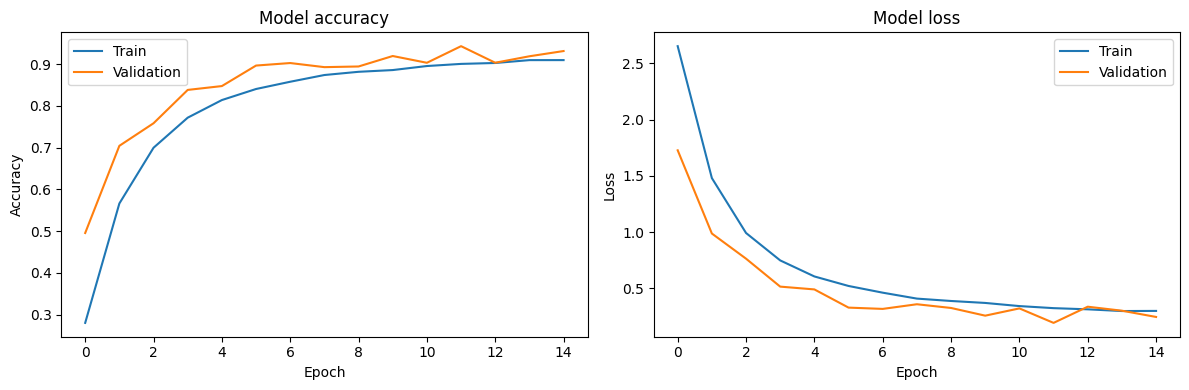

255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.84      0.79      0.82        95
                                 Apple___Black_rot       0.98      0.91      0.94        93
                          Apple___Cedar_apple_rust       0.92      0.83      0.87        41
                                   Apple___healthy       0.89      0.97      0.93       247
                               Blueberry___healthy       0.94      0.99      0.96       225
          Cherry_(including_sour)___Powdery_mildew       0.97      0.96      0.96       158
                 Cherry_(including_sour)___healthy       0.95      0.94      0.94       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.70      0.74        77
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       179
            

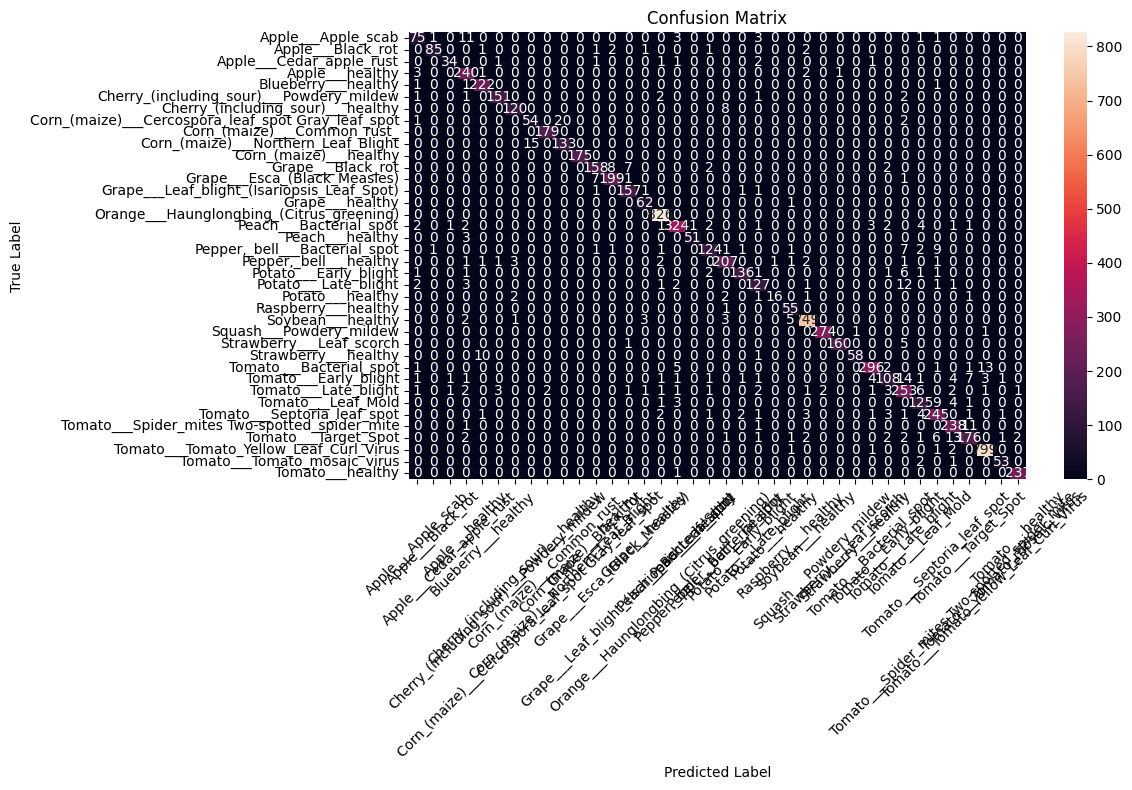


Model saved as 'plant_disease_model.h5'


In [ ]:
train_generator, validation_generator, test_generator = create_data_generators()

# Compilazione modello
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Addestramento
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

# Stampa dei risultati e valuta il modello
plot_training_history(history)
evaluate_model(model, validation_generator)

# Salva il modello
# Salvataggio del modello principale
model.save('/content/drive/My Drive/plantvillage_model_created.keras')
model.save('plant_disease_model.h5')
print("\nModel saved as 'plant_disease_model.h5'")